# Let's use emcee to see if we can infer the velocity of a star using Adrian's code.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import matplotlib as mpl
import emcee
import time
import corner

import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
from astropy.coordinates.builtin_frames.galactocentric import get_matrix_vectors

import aviary as av

%matplotlib inline

We want to infer the velocity and distance of a star from its proper motion in ra and dec, and 3-D position, marginalising over RV.

$$p(V_{xyz}, D|\mu_\alpha, \mu_\delta, \alpha, \delta, \pi) = p(\mu_\alpha, \mu_\delta, \alpha, \delta, \pi| V_{xyz}, D)~p(V_{xyz})~p(D)$$

Load the data.

In [2]:
df0 = pd.read_csv("../../data/gaia_mc5_velocities.csv")
m = np.isfinite(df0.vz.values)
df = df0.iloc[m]

Pick a star and set up variables.

In [3]:
i = 0
df1 = df.iloc[i]

pos = [df1.ra, df1.dec, df1.parallax]
pos_err = [df1.ra_error, df1.dec_error, df1.parallax_error]
pm = [df1.pmra, df1.pmdec]
pm_err = [df1.pmra_error, df1.pmdec_error]

Infer the vx, vy, vz velocities from the position and proper motion measurements.

In [5]:
ndim, nwalkers = 4, 24
inits = [df1.basic_vx, df1.basic_vy, df1.basic_vz, np.log(1./df1.parallax)]
p0 = np.random.randn(nwalkers, ndim) + inits

sampler = emcee.EnsembleSampler(nwalkers, ndim, av.lnprob, args=(pm, pm_err, pos, pos_err))

sampler.run_mcmc(p0, 1000, progress=True);

100%|██████████| 1000/1000 [02:14<00:00,  7.43it/s]


In [9]:
flat_samples = sampler.get_chain(discard=500, thin=5, flat=True)
params_inferred = np.median(flat_samples, axis=0)

In [10]:
print(av.lnprob(inits, pm, pm_err, pos, pos_err))
print(av.lnprob(params_inferred, pm, pm_err, pos, pos_err))

-3.3082832862777147
-0.5453870997015087


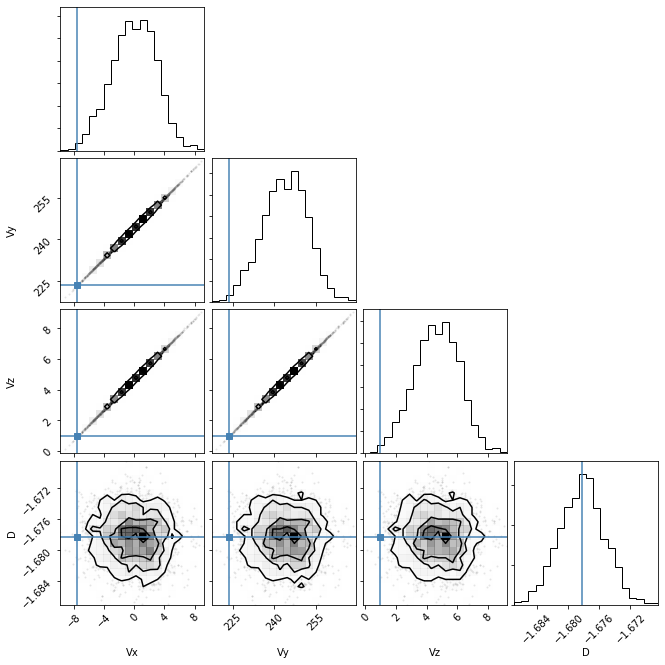

In [11]:
labels = ["Vx", "Vy", "Vz", "D"]
fig = corner.corner(flat_samples, truths=inits, labels=labels);

In [12]:
samps = sampler.get_chain()
np.shape(samps)

(1000, 24, 4)

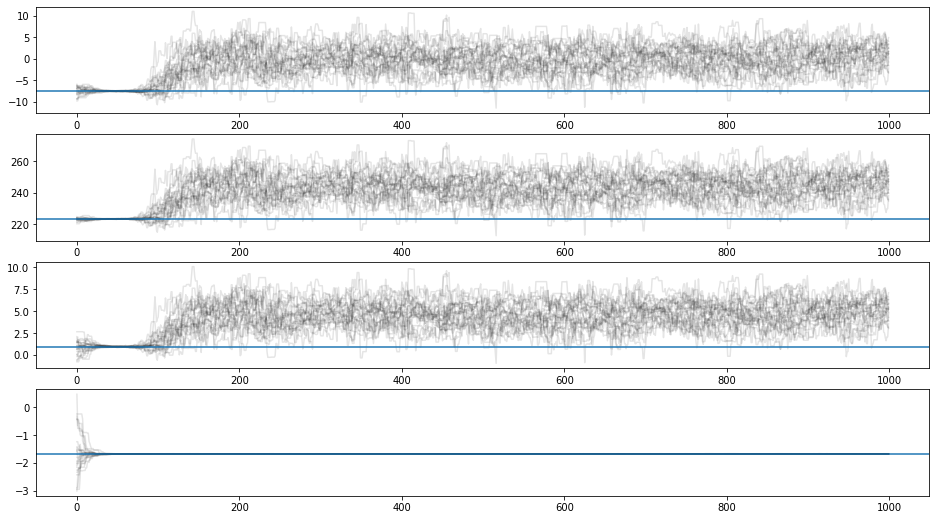

In [13]:
plt.figure(figsize=(16, 9))
for i in range(ndim):
    plt.subplot(ndim, 1, i+1)
    plt.plot(samps[:, :, i], "k", alpha=.1)
    plt.axhline(inits[i])

In [14]:
import astropy.stats as aps
import astropy.coordinates as coord
from astropy.coordinates.builtin_frames.galactocentric \
    import get_matrix_vectors
import astropy.units as u

import aviary as av

sun_xyz = [-8.122, 0, 0] * u.kpc
sun_vxyz = [12.9, 245.6, 7.78] * u.km/u.s

galcen_frame = coord.Galactocentric(galcen_distance=np.abs(sun_xyz[0]),
                                    galcen_v_sun=sun_vxyz,
                                    z_sun=0*u.pc)

# Pre-compute the rotation matrix to go from Galactocentric to ICRS
# (ra/dec) coordinates
R_gal, _ = get_matrix_vectors(galcen_frame, inverse=True)

    
    
c = coord.SkyCoord(ra=61.342*u.deg,
                   dec=17*u.deg,
                   distance=3*u.kpc,
                   pm_ra_cosdec=4.2*u.mas/u.yr,
                   pm_dec=-7.2*u.mas/u.yr,
                   radial_velocity=17*u.km/u.s)

test_galcen = c.transform_to(galcen_frame)

test_pm, test_rv = av.get_icrs_from_galactocentric(
    test_galcen.data.xyz, test_galcen.velocity.d_xyz, R_gal, sun_xyz,
    sun_vxyz)

pm = np.array([4.2, -7.2])
pm_err = np.array([.01, .01])
pos = np.array([61.342, 17., 1./3])
pos_err = np.array([.1, .1, .001])
vx = test_galcen.velocity.d_xyz[0].value
vy = test_galcen.velocity.d_xyz[1].value
vz = test_galcen.velocity.d_xyz[2].value

# # Run MCMC.
ndim, nwalkers = 4, 16
inits = [vx, vy, vz, np.log(3)]
p0 = np.random.randn(nwalkers, ndim)*1e-2 + inits
sampler = emcee.EnsembleSampler(nwalkers, ndim, av.lnprob,
                                args=(pm, pm_err, pos, pos_err))
sampler.run_mcmc(p0, 1000, progress=True);
flat_samples = sampler.get_chain(discard=500, flat=True)

100%|██████████| 1000/1000 [01:26<00:00, 11.50it/s]


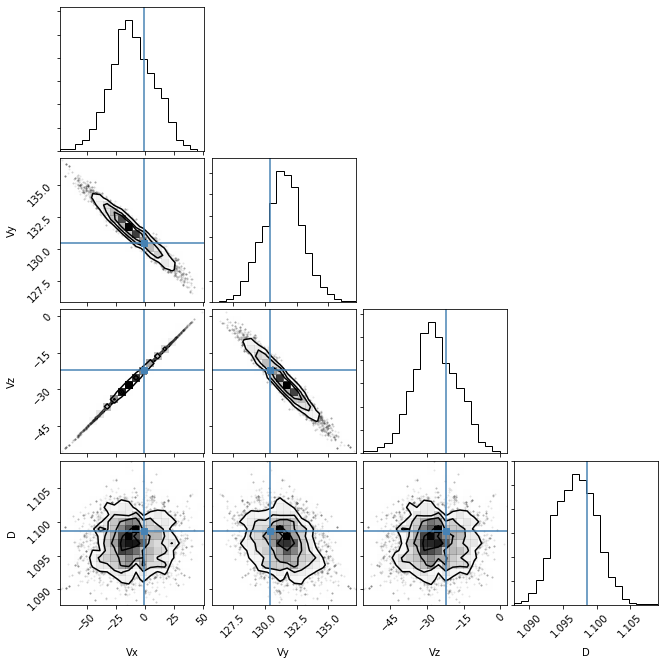

In [15]:
fig = corner.corner(flat_samples, truths=inits, labels=labels);

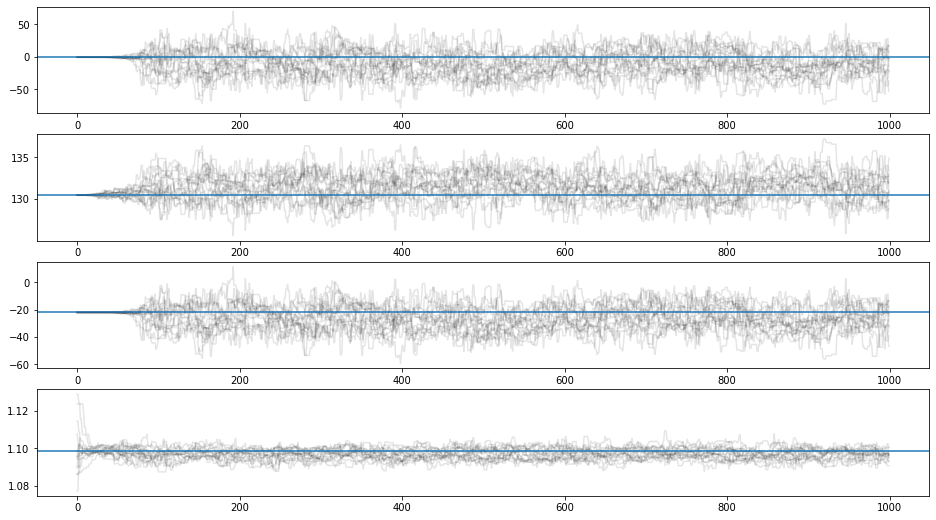

In [16]:
samps = sampler.get_chain()

plt.figure(figsize=(16, 9))
for i in range(ndim):
    plt.subplot(ndim, 1, i+1)
    plt.plot(samps[:, :, i], "k", alpha=.1)
    plt.axhline(inits[i])

In [17]:
np.median(flat_samples, axis=0)

array([-11.5296791 , 131.45226027, -27.13749924,   1.09695364])

Now figure out how many samples you need to converge and what results you want to save. Get ready to run on cluster.

In [57]:
def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i


def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2 * n)
    acf = np.fft.ifft(f * np.conjugate(f))[: len(x)].real
    acf /= 4 * n

    # Optionally normalize
    if norm:
        acf /= acf[0]

    return acf


# Automated windowing procedure following Sokal (1989)
def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1


def autocorr_new(y, c=5.0):
    f = np.zeros(y.shape[1])
    for yy in y:
        f += autocorr_func_1d(yy)
    f /= len(y)
    taus = 2.0 * np.cumsum(f) - 1.0
    window = auto_window(taus, c)
    return taus[window]

In [58]:
# Compute the estimators for a few different chain lengths
N = (10**(np.linspace(2, np.log10(len(samps[:, 0, 0])), 20))).astype(int)
tau_estimates = np.zeros((len(N), ndim))
for j in range(ndim):
    for i, n in enumerate(N):
        tau_estimates[i, j] = autocorr_new(samps[:n, :, j].T)

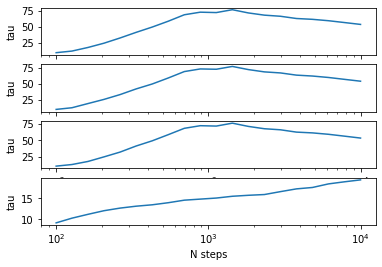

In [59]:
for i in range(ndim):
    plt.subplot(ndim, 1, i+1)
    plt.plot(N, tau_estimates[:, i]);
    plt.xscale("log")
    plt.xlabel("N steps")
    plt.ylabel("tau")

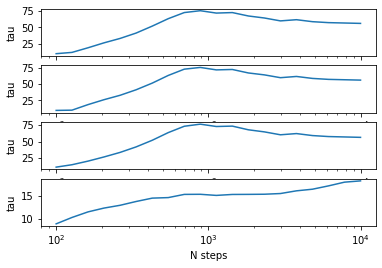

In [51]:
for i in range(ndim):
    plt.subplot(ndim, 1, i+1)
    plt.plot(N, tau_estimates[:, i]);
    plt.xscale("log")
    plt.xlabel("N steps")
    plt.ylabel("tau")

185.5666283067333
185.44636477214152
186.6444450888916
514.366916598025


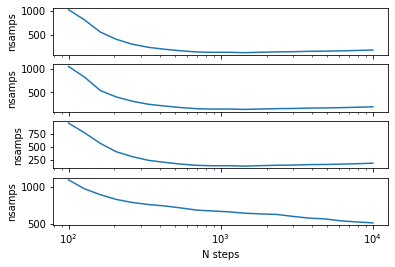

In [87]:
for i in range(ndim):
    plt.subplot(ndim, 1, i+1)
    plt.plot(N, len(samps[:, 0, 0])/tau_estimates[:, i]);
    plt.xscale("log")
    plt.xlabel("N steps")
    plt.ylabel("nsamps")
    print(len(samps[:, 0, 0])/tau_estimates[-1, i])

In [84]:
# Extract inferred parameters and uncertainties.¬
flat_samples = sampler.get_chain(discard=5000, thin=5, flat=True)
params_inferred = np.median(flat_samples, axis=0)
upper = np.percentile(flat_samples, 84, axis=0)
lower = np.percentile(flat_samples, 16, axis=0)
errp = upper - params_inferred
errm = params_inferred - lower
std = np.std(flat_samples, axis=0)

df2 = pd.DataFrame(dict({
    "kepid": df1.kepid,
    "vx_inferred": params_inferred[0],
    "vx_inferred_errp": errp[0],
    "vx_inferred_errm": errm[0],
    "vx_inferred_err": std[0],
    "vy_inferred": params_inferred[1],
    "vy_inferred_errp": errp[1],
    "vy_inferred_errm": errm[1],
    "vy_inferred_err": std[1],
    "vz_inferred": params_inferred[2],
    "vz_inferred_errp": errp[2],
    "vz_inferred_errm": errm[2],
    "vz_inferred_err": std[2],
    "distance_inferred": params_inferred[3],
    "distance_inferred_errp": errp[3],
    "distance_inferred_errm": errm[3],
    "distance_inferred_err": std[3]
    }), index=[0])

df2.to_csv("{}.csv".format(df1.kepid))

In [85]:
load_df = pd.read_csv("{}.csv".format(df1.kepid))

In [86]:
load_df

,Unnamed: 0,kepid,vx_inferred,vx_inferred_errp,vx_inferred_errm,vx_inferred_err,vy_inferred,vy_inferred_errp,vy_inferred_errm,vy_inferred_err,vz_inferred,vz_inferred_errp,vz_inferred_errm,vz_inferred_err,distance_inferred,distance_inferred_errp,distance_inferred_errm,distance_inferred_err
0,0,1432745,-0.257532,3.020493,2.97769,2.993427,243.281499,8.200421,8.091154,8.124589,4.533003,1.49237,1.473395,1.478934,-1.678242,0.002743,0.002714,0.002754
